# Learning Word Embeddings

Source: 😊[Day 12 - Special Data Types: Natural Language Processing](https://github.com/core-skills/12-text-processing) *repository*

> ☝️Before moving on with this notebook, ensure that you have:
- Downloaded the [hotels review data](https://github.com/kavgan/nlp-in-practice/blob/master/word2vec/reviews_data.txt.gz) (*reviews_data.txt.gz*) and placed it in the `./data` directory.
- Downloaded the GSWA data (*wamex_xml.zip*) and placed it in the `./data` directory.

**Overview**: Generating word embeddings using Gensim Word2Vec... Word Embeddings and Word2Vec
In this notebook, rather than loading word embeddings trained on large generic datasets, we train our own embedding models.

This notebook uses two types of datasets.
1. General Domain: 259,000 *hotel reviews* from [OpinRank](https://archive.ics.uci.edu/ml/datasets/opinrank+review+dataset) 
2. Domain Specific: *geological surveys* (GSWA)

**Supplementary Content**: ...s

Adapted from: [*Kavita Ganesan's tutorial*](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/) ([*repository*](https://github.com/kavgan/data-science-tutorials/tree/master/word2vec))

## Table of Contents
1. [Understanding Word2Vec parameters](#word2vec_parameters)
2. [Building general-domain word vectors](#general-domain_word_vectors)
3. [Building domain-specific word vectors](#domain-specific_word_vectors)

### Import Dependencies
- [gzip](https://docs.python.org/3/library/gzip.html) - library that we use to read data in .zip format
- [bokeh](https://bokeh.org/) - library that we use to interactively visualise word vectors 
- [gensim](https://radimrehurek.com/gensim/) - library that we will use to experiment with word embeddings/vectors

In [1]:
import gzip
from pathlib import Path
from typing import List
import zipfile
import json

import gensim
import bokeh
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
import pandas as pd
import nltk
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Set up the notebook environment and load helper functions

In [2]:
# Need the interactive Tools for Matplotlib
%matplotlib inline
# Plot formatting
plt.rcParams["figure.figsize"] = [12,6]
font = {'size':12}
matplotlib.rc('font', **font)

In [3]:
def read_input(input_file_path: str) -> List:
    '''Parses input file which is in gzip format'''
    assert input_file_path.endswith('.gz')
    
    corpus = []
    with gzip.open(input_file_path, 'rb') as f:
        for line in f: 
            # Perform pre-processing and return a list of words from each review text 
            corpus.append(gensim.utils.simple_preprocess(line))
    return corpus

In [4]:
def prettify_similarities(similarities: List[tuple]) -> List[str]:
    ''' Prettifies list of word similarities produced by Gensim.
    '''
    longest_str = max([len(sim[0]) for sim in similarities])
    print("\n".join([f'{idx+1}.\t{sim[0]:{longest_str+1}}\t{sim[1]*100:0.1f}%' for idx, sim in enumerate(similarities)]))

## Understanding Word2Vec Parameters<a name="word2vec_parameters"></a>

Before training our custom embedding models, we need to understand some of the models parameters. For reference, this is the command that we will use to train the model: `model = gensim.models.Word2Vec(sentences=documents, size=150, window=10, min_count=2, workers=10)`

#### Parameters of Interest
`sentences`: The corpus that the model will be trained on in the format of a list of lists of tokens.

`size`: The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. Typical sizes are 100-300. A value of 100-150 has worked well for me. 

`window`: The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

`min_count`: Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

`workers`: How many threads to use behind the scenes?

<hr/>

## 🏢 Learning General-Domain Word Embeddings <a name="general-domain_word_vectors"></a>
In this section we will learn word embeddings from a general-domain (hotel reviews). The hotel reviews contains:
- Full reviews of hotels in 10 different cities (Dubai, Beijing, London, New York City, New Delhi, San Francisco, Shanghai, Montreal, Las Vegas, Chicago) 
- There are about 80-700 hotels in each city 
- Extracted fields include date, review title and the full review 
- Total number of reviews: ~259,000

### Load and pre-process hotel reviews dataset
Before learning word embeddings, we need to load and pre-process the hotel reviews corpus. The helper function `read_input` aids us with this task. This helper parses the dataset that is in .zip format and composed of numerous .json data files. These are read into memory and pre-processed with Gensim's `gensim.utils.simple_preprocess()` function that converts each review into a list of tokens that are lower cased.

⚠️Loading the hotel reviews documents will take a few minutes

In [5]:
# The data_file path will be different depending on where you've copied the notebooks...
data_file = '../data/reviews_data.txt.gz'

# Read the tokenized reviews into a list each review item becomes a series of words so this becomes a list of lists
documents = read_input(input_file_path=data_file)

In [6]:
# Review the tokenized hotel reviews documents
print(documents[1])

['sep', 'great', 'budget', 'hotel', 'stayed', 'two', 'nights', 'at', 'aloft', 'on', 'the', 'most', 'recent', 'trip', 'to', 'china', 'the', 'hotel', 'was', 'very', 'modern', 'and', 'clean', 'the', 'room', 'was', 'spotless', 'and', 'comfortable', 'king', 'sized', 'bed', 'as', 'far', 'as', 'soft', 'beds', 'go', 'in', 'china', 'the', 'staff', 'was', 'very', 'punctual', 'and', 'went', 'out', 'of', 'the', 'way', 'to', 'help', 'my', 'every', 'need', 'including', 'going', 'to', 'store', 'across', 'the', 'street', 'to', 'purchase', 'china', 'mobile', 'sim', 'card', 'for', 'me', 'the', 'buffet', 'breakfast', 'was', 'okay', 'nothing', 'to', 'write', 'home', 'about', 'the', 'lcd', 'screen', 'had', 'movies', 'on', 'demand', 'for', 'rmb', 'and', 'had', 'good', 'selection', 'of', 'western', 'channels', 'including', 'hbo', 'cnn', 'bbc', 'star', 'world', 'etc', 'the', 'gym', 'was', 'small', 'had', 'selection', 'of', 'basic', 'weights', 'and', 'one', 'cable', 'machine', 'there', 'was', 'however', 'new',

### Training general-domain word embeddings
Here we set-up our Word2Vec embedding model and train it on the documents in the hotel reviews dataset. After training, we save it so it can be used without requiring re-training. 

⚠️ Training the embedding model will take a while due to the 250k documents

In [7]:
# Set-up model
model = gensim.models.Word2Vec(sentences=documents, size=150, window=10, min_count=2, workers=10)

In [8]:
# Train model on hotel reviews corpus
model.train(documents, total_examples=len(documents), epochs=10)

(303499431, 415193580)

In [9]:
# Save trained embedding models
model.save("../data/word2vec/word2vec_reviews.bin")

📣 Alternatively, load the embeddings that we've already pre-trained.

### Reviewing learnt word embeddings
Similar to the notebook [12.2.1 - Word vector visualisation with Gensim](https://github.com/core-skills/12-text-processing/blob/master/notebooks/12.2.1%20-%20Word%20vector%20visualization%20with%20Gensim.ipynb), we will explore the similarity of words represented with our general-domain embeddings.

#### Word Similarities

In [10]:
prettify_similarities(model.wv.most_similar(['polite']))

1.	courteous    	92.5%
2.	friendly     	83.7%
3.	cordial      	81.1%
4.	professional 	80.1%
5.	attentive    	78.4%
6.	curteous     	77.8%
7.	personable   	75.0%
8.	freindly     	74.9%
9.	gracious     	73.7%
10.	curtious     	72.5%


In [11]:
prettify_similarities(model.wv.most_similar(['dirty']))

1.	filthy  	86.5%
2.	unclean 	78.5%
3.	stained 	78.0%
4.	grubby  	76.9%
5.	smelly  	75.9%
6.	dusty   	74.4%
7.	dingy   	72.3%
8.	grimy   	71.8%
9.	mouldy  	71.8%
10.	soiled  	71.7%


In [12]:
prettify_similarities(model.wv.most_similar(['france']))

1.	germany   	66.7%
2.	canada    	66.2%
3.	spain     	63.0%
4.	hawaii    	62.1%
5.	lisbon    	61.4%
6.	mexico    	59.4%
7.	rome      	58.7%
8.	barcelona 	58.3%
9.	austria   	57.9%
10.	thailand  	57.5%


In [13]:
prettify_similarities(model.wv.most_similar(['shocked']))

1.	horrified  	80.4%
2.	amazed     	79.6%
3.	stunned    	75.3%
4.	appalled   	75.0%
5.	dismayed   	74.9%
6.	suprised   	73.9%
7.	astonished 	73.8%
8.	surprised  	73.7%
9.	astounded  	73.0%
10.	surprized  	71.6%


In [14]:
# Get everything related to stuff on the bed
prettify_similarities(model.wv.most_similar(positive=['bed', 'sheet', 'pillow'], negative=['couche'], topn=10))

1.	mattress 	73.3%
2.	duvet    	72.9%
3.	matress  	69.4%
4.	quilt    	66.6%
5.	pillows  	66.5%
6.	blanket  	66.0%
7.	quilts   	64.4%
8.	satin    	62.8%
9.	sheets   	62.6%
10.	bedding  	61.3%


In [15]:
# Similarity between two different words
print(f'Similarity between the words dirty and smelly: {model.wv.similarity(w1="dirty",w2="smelly"):0.3}')

Similarity between the words dirty and smelly: 0.759


In [16]:
# Similarity between two identical words
print(f'Similarity between the same word dirty: {model.wv.similarity(w1="dirty",w2="dirty"):0.3}')

Similarity between the same word dirty: 1.0


In [17]:
# similarity between two unrelated words
print(f'Similarity between the words dirty and clean: {model.wv.similarity(w1="dirty",w2="clean"):0.3}')

Similarity between the words dirty and clean: 0.281


In [18]:
# Which one is the odd one out in this list?
odd_one_out_list_1 = ["cat", "dog", "france"]
print(f'Which words doesnt belong in the set {odd_one_out_list_1}? Odd one out: {model.wv.doesnt_match(odd_one_out_list_1)}')

Which words doesnt belong in the set ['cat', 'dog', 'france']? Odd one out: france


C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [19]:
# Which one is the odd one out in this list?
odd_one_out_list_2 = ["bed","pillow","duvet","shower"]
print(f'Which words doesnt belong in the set {odd_one_out_list_2}? Odd one out: {model.wv.doesnt_match(odd_one_out_list_2)}')

Which words doesnt belong in the set ['bed', 'pillow', 'duvet', 'shower']? Odd one out: shower


## Visualising the word vectors in 2D space

Here we use a dimensionality reduction and visualisation package from Scikit-Learn, t-Distributed Stochastic Neighbor Embedding (t-SNE), which is particularly suited for visualising high dimensional data. Another popular options for dimensionality reduction is Principal Component Analysis (PCA).

Note: the dimension of our word vectors by choice is 150, typical numbers could be 50, 100, and 300. Among these numbers, a dimension of 300 has been shown as most effective in capturing the syntatic and semantic information of a word. However, it will take much longer to train. 

In [20]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,150), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

### Visualising closest words in 2D

C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


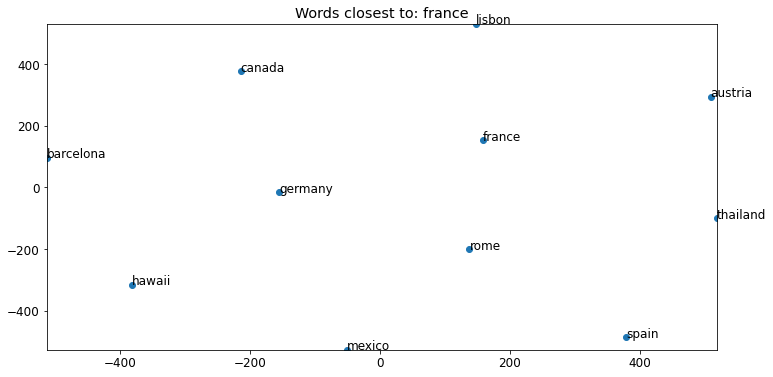

In [21]:
display_closestwords_tsnescatterplot(model.wv, "france")

## ⚙️ Learning Domain-Specific Word Embeddings <a name="domain-specific_word_vectors"></a>

Word embeddings are interesting and thought provoking but
- What insights can we gain from them?
- How do we apply them to industry data?

This section of the notebook will explore word embeddings and their application to geological survey data (GSWA).

### Loading a small sample of Geological Survey of Western Australia (GSWA) data

In [22]:
gswa_corpus_file="../data/wamex_xml.zip"

In [23]:
gswa_corpus = list()
with zipfile.ZipFile(gswa_corpus_file, "r") as z:
    for filename in z.namelist():
        with z.open(filename) as f:
            # load the json file
            # The resulting `content` is a list
            content = json.loads(f.read()) 
            # Convert content to a string   
            content = "".join(content)
            # Add to the data list
            gswa_corpus.append(content)

By previewing the data that we have loaded, we can easily see that it is very different to the hotel reviews dataset.

In [24]:
print(gswa_corpus[0][:500])

Combined Reporting Application Pending Status: Sheet 1:250 000: Kalgoorlie (SH 51-09) Sheet 1:100 000: Kalgoorlie (3136) Project Operator: Cazaly Resources Limited Author: M Watts Date: September 2006 Distribution: 1.Department of Industry and Resources 2.Cazaly Resources Limited Cazaly Resources Limited September 2006 2 Figure 2: Castle Hill Project Tenement Location Plan, 1: 75 000 scale 6 Figure 3: Regional Geology with Exploration Index Map, 1:75 000 scale 8Cazaly Resources Limited September


In [25]:
def read_input(input_file):
    """This method reads the input file which is in zip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))

    data = list()
    with zipfile.ZipFile(input_file, "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
        print(len(z.namelist()))
        for i, filename in enumerate(z.namelist()):
            # print(filename)
            # df = pd.read_json(filename)
            if (i%100==0):
                logging.info ("read {0} reports".format (i))
            with z.open(filename) as f:
                # load the json file
                # The resulting `content` is a list
                content = json.loads(f.read()) 
                # Convert content to a string   
                content = "".join(content)
                if len(content) >= 10:
                    # Add to the data list
                    yield gensim.utils.simple_preprocess (content)
                else:
                    logging.info("removed {0} because of small size".format (filename))

Here we'll perform basic pre-processing of the geological surveys using Gensim's `simple_preprocess` function. A result of this is a corpus of tokenized and cased documents.

In [26]:
processed_gswa_corpus = [gensim.utils.simple_preprocess(doc) for doc in gswa_corpus]

In [27]:
# Review the first documents top 25 words. See how they have been pre-processed and tokenized.
print(processed_gswa_corpus[0][:25])

['combined', 'reporting', 'application', 'pending', 'status', 'sheet', 'kalgoorlie', 'sh', 'sheet', 'kalgoorlie', 'project', 'operator', 'cazaly', 'resources', 'limited', 'author', 'watts', 'date', 'september', 'distribution', 'department', 'of', 'industry', 'and', 'resources']


### Training word embedding model off of domain-specific text.

Note: we are required to use bigrams to aid our model due to domain-specific terms.

⚠️Training the domain-specific embeddings will take 30-60 minutes.

In [28]:
# Build phrases and bigrams to train our word2vec model on
phrases = gensim.models.Phrases(documents, min_count=1, threshold=1)
bigrams = gensim.models.phrases.Phraser(phrases)

# Note: we're referring to the model as gswa. This allows us
# to make a contrast between the pretrained word embeddings and the domain-specific ones. 
gswa_model = gensim.models.Word2Vec(bigrams[documents], size=50, window=10, min_count=2, workers=12)
gswa_model.train(bigrams[documents],total_examples=len(documents), epochs=10)

(248780721, 329928610)

In [29]:
gswa_model.save("../data/word2vec/word2vec_gswa.bin")

📣 Alternately, if you have downloaded the pre-trained embeddings, you can skip training and load them directly.

## Looking at domain-specific outputs

In [30]:
print(list(gswa_model.wv.vocab.keys())[:100])

['oct', 'nice', 'trendy', 'hotel', 'location', 'not_too', 'bad', 'stayed_in', 'this_hotel', 'for', 'one_night', 'as', 'this', 'is', 'fairly_new', 'place', 'some', 'of', 'the', 'taxi_drivers', 'did_not', 'know_where', 'it', 'was', 'and', 'or', 'want_to', 'drive', 'there', 'once', 'have', 'eventually_arrived', 'at', 'very_pleasantly', 'surprised', 'with', 'decor', 'lobby', 'ground_floor', 'area', 'very_stylish', 'modern', 'found', 'reception_staff', 'geeting', 'me', 'aloha', 'bit', 'out_of', 'but_guess', 'they_are', 'briefed', 'to_say', 'that', 'to_keep', 'up', 'coroporate', 'image', 'starwood_preferred', 'guest_member', 'given', 'small_gift', 'upon_check', 'in', 'only_couple', 'fridge_magnets', 'gift_box', 'but_nevertheless', 'nice_gesture', 'my', 'room', 'roomy', 'there_are', 'tea', 'coffee_facilities', 'each', 'you_get', 'two', 'complimentary_bottles', 'water', 'plus', 'toiletries', 'by', 'bliss', 'not', 'great', 'last', 'metro_stop', 'you', 'then', 'need_to', 'take_taxi', 'but', 'if_

In [34]:
prettify_similarities(gswa_model.wv.most_similar(['gold']))

1.	red         	76.8%
2.	blue        	75.3%
3.	dazzling    	74.3%
4.	white_zebra 	73.6%
5.	golden      	72.2%
6.	beige       	72.0%
7.	white       	70.7%
8.	gilded      	70.3%
9.	scheme      	69.7%
10.	silver      	69.5%


In [35]:
prettify_similarities(gswa_model.wv.most_similar(['iron']))

1.	an_iron       	90.3%
2.	hair_dryer    	89.8%
3.	hairdryer     	89.6%
4.	ironing_board 	85.9%
5.	trouser_press 	85.7%
6.	hairdrier     	85.3%
7.	iron_amp      	85.0%
8.	ironing       	84.5%
9.	blow_dryer    	84.0%
10.	hair_drier    	83.1%


In [36]:
# get everything related to stuff on the commodity
prettify_similarities(gswa_model.wv.most_similar(positive = ["gold",'commodity','ore'], negative = ['rock']))

1.	westerners_who 	69.7%
2.	publicized     	69.3%
3.	roomsking      	68.0%
4.	cotton_bads    	67.3%
5.	peers          	66.9%
6.	long_wheelbase 	66.6%
7.	milk_creamer   	66.6%
8.	risking_your   	66.0%
9.	maintaing      	65.2%
10.	an_ian         	65.1%


In [37]:
# similarity between two different words
print(f'Similarity between two different words: {gswa_model.wv.similarity(w1="gold",w2="ore"):0.3}')

Similarity between two different words: 0.158


In [38]:
# similarity between two identical words
print(f'Similarity between the same word: {gswa_model.wv.similarity(w1="gold",w2="gold"):0.3}')

Similarity between the same word: 1.0


In [39]:
# similarity between two unrelated words
print(f'Similarity between unrelated words: {gswa_model.wv.similarity(w1="gold",w2="rock"):0.3}')

Similarity between unrelated words: 0.39


In [40]:
# Which one is the odd one out in this list?
odd_one_out_list_gswa = ["gold", "rock", "copper"]
print(f'Which words doesnt belong in the set {odd_one_out_list_gswa}? Odd one out: {gswa_model.wv.doesnt_match(odd_one_out_list_gswa)}')

Which words doesnt belong in the set ['gold', 'rock', 'copper']? Odd one out: rock


C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Comparing our domain-specific embeddings with embeddings trained on a different dataset (news articles).

- What are the nearest terms to 'commodity', 'ore', 'rock', etc.

Unfortunately due to the size of pre-trained word embedding models they have been omitted from this comparison. However, the code below shows how to load the Google news word2vec embedding model. This model is trained on 100 billion words and is 1.6GB in size (massive!).

In [41]:
# Define function to compare top-n similariries for a given word between two embedding models.
def compare_words(word, topn, model1, model2):
    similarWordsModel1 = model1.wv.most_similar(positive=word, topn=topn)
    similarWordsModel2 = model2.wv.most_similar(positive=word,topn=topn)

    print(f'Top {topn} words similar to {word}\n(format: n | model 1 | model 2 )\n')
    for n in range(topn):
        print(f'{n+1} |{similarWordsModel1[n][0]:<15} | {similarWordsModel2[n][0]:<15}')

In [42]:
# Looking at the word 'commodity'
compare_words(word = 'commodity', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to commodity
(format: n | model 1 | model 2 )

1 |rarity          | publicized     
2 |necessity       | exercise_bike  
3 |nowadays        | liquids        
4 |brutally        | sacrificing_little
5 |unusually       | cotton_bads    


In [43]:
# Looking at the word 'ore'
compare_words(word = 'ore', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to ore
(format: n | model 1 | model 2 )

1 |tre             | pas_cher       
2 |stanze          | buena_ubicacion
3 |esta            | posizione_con  
4 |magique         | cher_pour      
5 |haber           | lumire         


In [44]:
# Looking at the word 'rock'
compare_words(word = 'rock', topn = 5, model1 = model, model2 = gswa_model)

Top 5 words similar to rock
(format: n | model 1 | model 2 )

1 |rocks           | beatles        
2 |snapper         | skate          
3 |rosey           | horse          
4 |carnation       | du_soleil      
5 |flame           | performers     


### Visualising the domain-specific word vectors in 2D space

In [45]:
def display_closestwords_tsnescatterplot(model, word):
    arr = np.empty((0,50), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


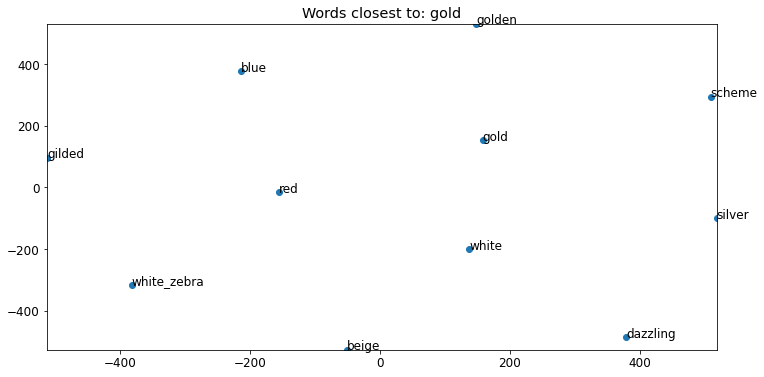

In [46]:
display_closestwords_tsnescatterplot(model = gswa_model.wv, word = "gold")

### Visualising all of the words in the domain-specific corpus vocabulary

In [47]:
# Set-up t-SNE model for 2 dimensional reduction
tsne = TSNE(n_components=2)

In [48]:
X = gswa_model[gswa_model.wv.vocab]
# Shape of our model before t-SNE
print(f'Shape of model before t-SNE: {X.shape}')

C:\Users\22917746\AppData\Local\Temp/ipykernel_34324/3276302873.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = gswa_model[gswa_model.wv.vocab]


Shape of model before t-SNE: (271284, 50)


Here we'll fit a t-SNE model to our data. However, as our corpus is quite large, we'll first subset it to help with comptuation time.

In [49]:
# Number of points to model
points = 2500

In [50]:
# Fitting subset of data to t-SNE
X_limited = X[:points]
X_tsne = tsne.fit_transform(X_limited)

# Uncomment line below to fit entire model to t-SNE
# X_tsne = tsne.fit_transform(X)

C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\22917746\Miniconda3\envs\core-nlp-course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


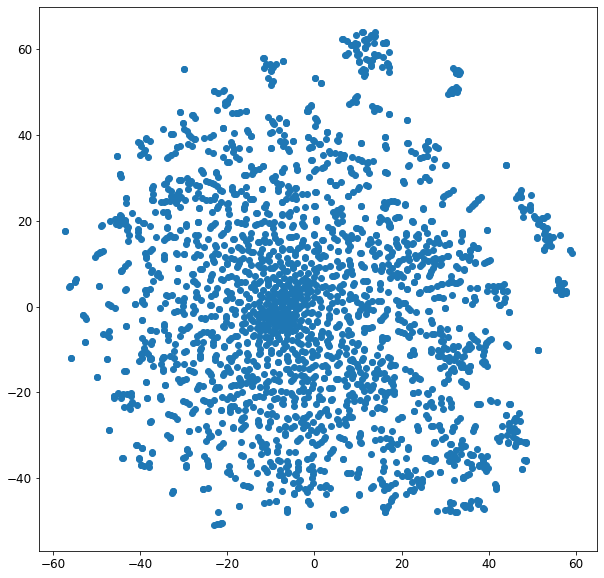

In [51]:
# Plot dimensionality reduced word scatterplot
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

### Interactive Visualisation


Refer to https://www.datascience.com/resources/notebooks/word-embeddings-in-python, and also for ideas of incoporating POS and bigrams into word2vec training.

In [52]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

Launch interactive visualisation of word embeddings

In [53]:
interactive_tsne(list(gswa_model.wv.vocab.keys())[:points], X_tsne)

Loading BokehJS ...